### Import all the packages 

In [2]:
import numpy as np
import matplotlib.pyplot as plt
import torch
import ot
from tqdm import tqdm

# First step is to be able to sample from the Pojected Langevin Monte Carlo Algorithm 
## We saple from a Dirichlet distribution of parameter $a = (5,10,5)$

Let $\mathcal{K} := \Delta_{d + 1} = \{x \in \mathbb{R}_{+}^{d} : \mathbf{1}^{\top}x \leq 1\}$ and $\pi_{Dirichlet}(x) \propto \exp(-f(x)); \quad f(x) = -\sum_{i=1}^{d} a_{i}\log x_{i} - a_{d + 1}\log\left(1 - \sum_{i=1}^{d}x_{i}\right)$

The projected Langevin Monte Carlo (PLMC) is defined as follows


$$X_{k+1} = \text{Proj}_\mathcal{K}\left( X_k - \frac{\eta}{2} \nabla f(X_k) + \sqrt{\eta} \, \xi_k \right),\; \eta>0 $$

see (Bubeck 2015, **Sampling from a log-concave distribution with Projected Langevin Monte Carlo**)

### Projection onto $\mathcal{K}$

In [3]:
def project_to_simplex(v):
    n_features = v.shape[0]
    u = np.sort(v)[::-1]
    cssv = np.cumsum(u)
    cond = u * np.arange(1, n_features+1) > (cssv - 1)
    
    if not np.any(cond):
        # Aucun élément ne satisfait la condition -> projeter sur zéro
        return np.zeros_like(v)
    
    rho = np.nonzero(cond)[0][-1]
    theta = (cssv[rho] - 1) / (rho + 1.0)
    w = np.maximum(v - theta, 0)
    return w
#--------------------------------------------------------------------------------
def project_to_simplex_sum_leq_one(v):
    """
    Projection sur le simplexe tronqué { x >= 0, sum x <= 1 }
    """
    w = np.maximum(v, 0)
    s = np.sum(w)
    if s <= 1:
        #print('inf à 1')
        return w
    else:
        # Projection sur le simplexe standard {x >= 0, sum x = 1}
        #print('real projection')
        return project_to_simplex(w)


### Gradient of $f$

In [4]:
def grad_f(x, a, epsilon):
    """
    Gradient de f(x) = - sum_i a_i log(x_i) - a_{d+1} log(1 - sum_i x_i)
    x : array de taille d
    a : array de taille d+1 (avec a_1,...,a_d et a_{d+1})
    """
    d = len(x)
    grad = np.zeros_like(x)
    s = np.sum(x)
    for i in range(d):
        if x[i]==0:
            x[i]= epsilon
        grad[i] = - a[i] / x[i] + a[d] / (1 - s)
    return grad

In [5]:
def projected_langevin_MAPLA(a, stepsize, n_iters, x0=None):
    """
    Projected Langevin Algorithm pour la densité cible de MAPLA
    
    a : array de taille d+1
    stepsize : pas de temps (learning rate), noté eta
    n_iters : nombre d'itérations
    x0 : point initial, array de taille d
    seed : pour reproductibilité
    """
    #if seed is not None:
        #np.random.seed(seed)
    
    d = len(a) - 1  # a est de taille d+1
    if x0 is None:
        x = np.random.dirichlet(np.ones(d))
        x = 0.9 * x  # pour s'assurer que sum(x) < 1
    else:
        x = np.copy(x0)
    #print('initial',x)
    samples = []
    for _ in range(n_iters):
        grad = grad_f(x, a, 0.002)
        noise = np.random.normal(0, 1, size=d)
        x = x - stepsize * grad + np.sqrt(2 * stepsize) * noise
        #print('post bruit',x)
        #print('____', grad)
        x = project_to_simplex_sum_leq_one(x) 
        #print('projected', x)
        samples.append(np.copy(x))
    
    return np.array(samples)


### **Simulation**

In [34]:
if __name__ == "__main__":
    d = 2
    a = np.array([5.0, 10.0, 5.0])  # a_1, a_2, a_3, a_4
    N_sample = 1000
    n_iters = 1000
    Dstrib = [projected_langevin_MAPLA(a, stepsize= 1e-3, n_iters=n_iters)[-1] for _ in tqdm(range(N_sample))]


    samples = np.random.dirichlet(a, size=N_sample)
    samples_2d = samples[:, :2]

  0%|          | 0/1000 [00:00<?, ?it/s]/tmp/ipykernel_1195/3854873682.py:13: RuntimeWarning: divide by zero encountered in scalar divide
  grad[i] = - a[i] / x[i] + a[d] / (1 - s)
100%|██████████| 1000/1000 [00:27<00:00, 36.70it/s]


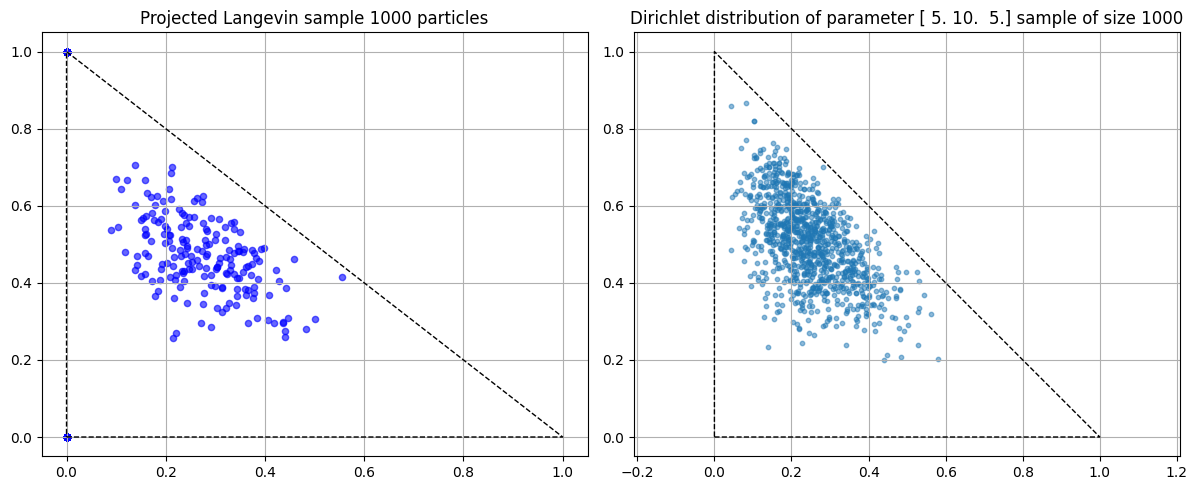

In [35]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # axs est un tableau d'axes

# Premier graphique : W₂ distance
axs[0].scatter(np.array(Dstrib)[:, 0], np.array(Dstrib)[:, 1], c='blue', s=20, alpha=0.6)
axs[0].plot([0, 1, 0, 0], [0, 0, 1, 0], 'k--', linewidth=1)
axs[0].grid(True)
axs[0].set_title(f"Projected Langevin sample {N_sample} particles")


# Deuxième graphique : autre métrique (exemple)
axs[1].scatter(samples_2d[:, 0], samples_2d[:, 1], s=10, alpha=0.5)
axs[1].plot([0, 1, 0, 0], [0, 0, 1, 0], 'k--', linewidth=1)
axs[1].grid(True)
axs[1].set_title(f"Dirichlet distribution of parameter {a} sample of size {N_sample}")
axs[1].axis('equal')

plt.tight_layout()
plt.savefig("img/dirichlet_sample_c.png", dpi=300, bbox_inches='tight')
plt.show()

### **About Convergence** : Initialize $\texttt{N} = 200$ particles and compute the following distance between emperical measures for every $\texttt{log\_every} = 20$ iterations
$$W_2(\hat{P}_{PLMC}, \hat{P}_{Dirichlet})$$ 

## PLMC with Torch

In [24]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

def project_to_simplex_torch(v):
    v = torch.clamp(v, min=0.0)
    s = torch.sum(v)
    if s <= 1.0:
        return v
    else:
        u, _ = torch.sort(v, descending=True)
        cssv = torch.cumsum(u, dim=0)
        rho = torch.nonzero(u * torch.arange(1, len(v)+1, dtype=v.dtype, device=v.device) > (cssv - 1), as_tuple=False)
        if rho.numel() == 0:
            return torch.zeros_like(v)
        rho = rho[-1].item()
        theta = (cssv[rho] - 1) / (rho + 1.0)
        return torch.clamp(v - theta, min=0.0)

def projected_langevin_MAPLA_particles(a_np, N=200, stepsize=1e-3, n_iters=500, log_every=20, epsilon=1e-5):
    """
    Simule N particules évoluant selon le Projected Langevin Algorithm.
    Retourne une liste des mesures empiriques (positions des particules) à chaque log_every itérations.
    """
    a = torch.tensor(a_np, dtype=torch.float32, device=device)
    d = len(a_np) - 1
    X = torch.tensor(np.random.dirichlet(np.ones(d), size=N) * 0.9, dtype=torch.float32, device=device)

    measures = []
    for t in range(n_iters):
        X = X.clone().detach().requires_grad_(False)
        X_clamped = torch.clamp(X, min=epsilon)
        s = torch.sum(X_clamped, dim=1, keepdim=True)
        s = torch.clamp(s, max=1.0 - epsilon)
        grad = -a[:-1] / X_clamped + a[-1] / (1.0 - s)
        noise = torch.randn_like(X)
        X = X - stepsize * grad + torch.sqrt(torch.tensor(2 * stepsize)) * noise
        X = torch.stack([project_to_simplex_torch(xi) for xi in X])

        if t % log_every == 0:
            measures.append(X.clone())

    return measures


## $W_2$ distance 

In [25]:
def ot_distance(points_a: torch.Tensor, points_b: torch.Tensor) -> float:
    """
    Calcule la distance de Wasserstein de 2ème ordre entre deux ensembles de points.
    """
    Na = points_a.shape[0]
    Nb = points_b.shape[0]
    
    # Calcul de la matrice des coûts
    cost_matrix = ot.utils.dist(points_a.cpu().numpy(), points_b.cpu().numpy())
    
    # Assignation de la masse uniforme
    a = np.ones(Na) / Na
    b = np.ones(Nb) / Nb
    
    # Calcul de la distance de Sinkhorn
    loss = ot.sinkhorn2(a=a, b=b, M=cost_matrix, reg=0.01, stopThr=1e-6)
    return loss

## We can consider another distance : the Energy Distance 
$$ED(\hat{P}_{PLMC}, \hat{P}_{Dirichlet}) = \frac{2}{N^{2}}\sum_{i,j=1}^{N}\|X_{i} - Y_{j}\| - \frac{1}{N^{2}}\sum_{i,j=1}^{N}\|X_{i} - X_{j}\| - \frac{1}{N^{2}}\sum_{i,j=1}^{N}\|Y_{i} - Y_{j}\|$$

where $X_i$ and $Y_i$ are the support of $\hat{P}_{PLMC}, \hat{P}_{Dirichlet}$ repectively

In [26]:
def energy_distance(points_a: torch.Tensor, points_b: torch.Tensor) -> torch.Tensor:
    A = torch.cdist(x1=points_a, x2=points_b, p=2).mean(dim=(-1, -2))
    B = torch.cdist(x1=points_a, x2=points_a, p=2).mean(dim=(-1, -2))
    C = torch.cdist(x1=points_b, x2=points_b, p=2).mean(dim=(-1, -2))
    return 2 * A - B - C

### **Simulation** 

In [61]:
if __name__ == "__main__":
    d = 2
    a = np.array([5.0, 10.0, 5.0])
    N = 200  # Nombre de particules
    max_iters = 1000
    log_every = 10
    
    # Mesures évolutives via PLA
    empirical_measures = projected_langevin_MAPLA_particles(
        a, N=N, stepsize=1e-3, n_iters=max_iters, log_every=log_every
    )
    
    # Référence : Dirichlet
    dirichlet_samples = torch.tensor(
        np.random.dirichlet(a[:d], size=N),
        dtype=torch.float32, device=device
    )
    
    # Distance de Sinkhorn à chaque pas
    eng_distances = []
    ot_distances = []
    for X in empirical_measures:
        eng_dist = energy_distance(X, dirichlet_samples)
        ot_dist = ot_distance(X, dirichlet_samples)
        eng_distances.append(eng_dist)
        ot_distances.append(ot_dist)


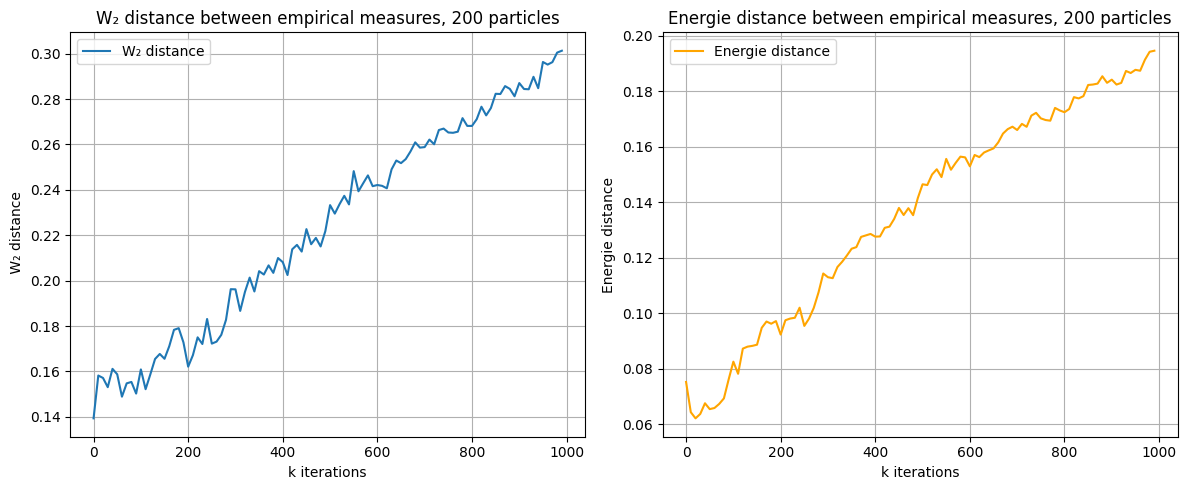

In [62]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # axs est un tableau d'axes

# Premier graphique : W₂ distance
axs[0].plot(np.arange(0, max_iters, log_every), eng_distances, label='W₂ distance')
axs[0].set_xlabel("k iterations")
axs[0].set_ylabel(" W₂ distance")
axs[0].legend()
axs[0].grid(True)
axs[0].set_title("W₂ distance between empirical measures, 200 particles")


# Deuxième graphique : autre métrique (exemple)
axs[1].plot(np.arange(0, max_iters, log_every), ot_distances, color='orange', label='Energie distance')
axs[1].set_xlabel("k iterations")
axs[1].set_ylabel("Energie distance")
axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Energie distance between empirical measures, 200 particles")

plt.tight_layout()
plt.savefig("img/dist_ed_W2_c.png", dpi=300, bbox_inches='tight')
plt.show()

### The idea is that PLMC places increasing mass on the boundary of $\mathcal{K}$ as $t$ grows—especially at the corners. As a result, the Wasserstein distance increases. To illustrate this behavior, let's remove the particles stuck at the corners.

In [63]:
if __name__ == "__main__":
    d = 2
    a = np.array([10.0, 10.0, 10.0])  # Paramètres de la Dirichlet
    N = 200  # Nombre de particules
    max_iters = 1000
    log_every = 10
    N_moy = 20
    
    
    def filter_strict_non_corner(X):
        mask = (X[:, 0] > 0) & (X[:, 1] > 0) & (X[:, 0]+X[:, 1] < 1)
        return X[mask]

    distances_all = []
    len_part_all = []
    for _ in tqdm(range(N_moy)):
        distances = []
        len_part = []
        empirical_measures = projected_langevin_MAPLA_particles(
        a, N=N, stepsize=1e-3, n_iters=max_iters, log_every=log_every
    )
        dirichlet_samples = torch.tensor(
        np.random.dirichlet(a[:d], size=N),
        dtype=torch.float32, device=device
    )
        for X in empirical_measures:
            X_filtered = filter_strict_non_corner(X)
            len_part.append(X_filtered.shape[0])
            if len(X_filtered) == 0:
                distances.append(np.nan)
                continue
            dist = ot_distance(X_filtered, dirichlet_samples)
            distances.append(dist)
        distances_all.append(distances)
        len_part_all.append(len_part)
        
        
    distances_all = np.array(distances_all)
    mean_distances = np.nanmean(distances_all, axis=0)
    len_part_all = np.array(len_part_all)
    mean_len_part_all = np.nanmean(len_part_all, axis=0)



100%|██████████| 20/20 [01:38<00:00,  4.93s/it]


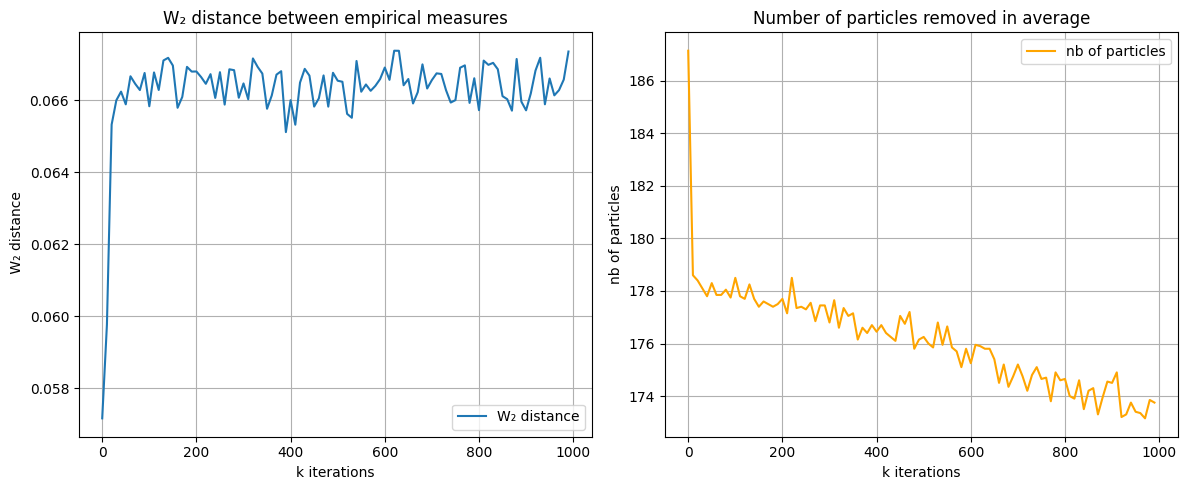

In [64]:
fig, axs = plt.subplots(1, 2, figsize=(12, 5))  # axs est un tableau d'axes

# Premier graphique : W₂ distance
axs[0].plot(np.arange(0, max_iters, log_every), mean_distances, label='W₂ distance')
axs[0].set_xlabel("k iterations")
axs[0].set_ylabel(" W₂ distance")
axs[0].legend()
axs[0].grid(True)
axs[0].set_title("W₂ distance between empirical measures")


# Deuxième graphique : autre métrique (exemple)
axs[1].plot(np.arange(0, max_iters, log_every), mean_len_part_all, color='orange', label='nb of particles')
axs[1].set_xlabel("k iterations")
axs[1].set_ylabel("nb of particles")
axs[1].legend()
axs[1].grid(True)
axs[1].set_title("Number of particles removed in average")

plt.tight_layout()
plt.savefig("img/dist_W2_boundless.png", dpi=300, bbox_inches='tight')
plt.show()

### Projected Langevin Monte Carlo with a Metropolis Filter 

In [40]:
def log_dirichlet_density(x, alpha, epsilon=1e-5):
    x = torch.clamp(x, min=epsilon)
    s = torch.sum(x)
    if s >= 1.0:
        return -float('inf')
    return torch.sum((alpha[:-1] - 1) * torch.log(x)) + (alpha[-1] - 1) * torch.log(1.0 - s)

def mala_step(x, grad, alpha, stepsize, epsilon):
    d = len(x)
    noise = torch.randn_like(x)
    proposal = x - stepsize * grad + torch.sqrt(torch.tensor(2 * stepsize)) * noise
    proposal = project_to_simplex_torch(proposal)

    # Log densities
    log_p_current = log_dirichlet_density(x, alpha, epsilon)
    log_p_proposal = log_dirichlet_density(proposal, alpha, epsilon)

    # Proposal densities q(x'|x) and q(x|x')
    def log_q(x_from, x_to, grad_from):
        diff = x_to - x_from + stepsize * grad_from
        return -torch.sum(diff**2) / (4 * stepsize)

    grad_proposal = -alpha[:-1] / torch.clamp(proposal, min=epsilon) + alpha[-1] / (1.0 - torch.sum(proposal))

    log_q_forward = log_q(x, proposal, grad)
    log_q_backward = log_q(proposal, x, grad_proposal)

    log_accept_ratio = log_p_proposal + log_q_backward - log_p_current - log_q_forward
    accept = torch.rand(1).item() < torch.exp(min(log_accept_ratio, torch.tensor(0.0)))

    return proposal if accept else x

def projected_langevin_MALA_particles(a_np, N=200, stepsize=1e-3, n_iters=500, log_every=10, epsilon=1e-5):
    a = torch.tensor(a_np, dtype=torch.float32, device=device)
    d = len(a_np) - 1
    X = torch.tensor(np.random.dirichlet(np.ones(d), size=N) * 0.9, dtype=torch.float32, device=device)

    measures = []
    for t in range(n_iters):
        X_new = []
        for xi in X:
            xi = xi.detach()
            xi_clamped = torch.clamp(xi, min=epsilon)
            s = torch.sum(xi_clamped)
            s = torch.clamp(s, max=1.0 - epsilon)
            grad = -a[:-1] / xi_clamped + a[-1] / (1.0 - s)
            xi_new = mala_step(xi, grad, a, stepsize, epsilon)
            X_new.append(xi_new)
        X = torch.stack(X_new)

        if t % log_every == 0:
            measures.append(X.clone())

    return measures


### **Simulations**

In [41]:
if __name__ == "__main__":
    d = 2
    a = np.array([5.0, 10.0, 5.0])  # Paramètres de la Dirichlet
    N = 200  # Nombre de particules
    max_iters = 1000
    log_every = 10
    N_moy = 5
    
    # Distance de Sinkhorn à chaque pas
    distances_all = []
    for _ in tqdm(range(N_moy)):
        distances = []
        empirical_measures = projected_langevin_MALA_particles(
        a, N=N, stepsize=1e-3, n_iters=max_iters, log_every=log_every
    )
        dirichlet_samples = torch.tensor(
        np.random.dirichlet(a[:d], size=N),
        dtype=torch.float32, device=device
    )
        for X in empirical_measures:
            dist = ot_distance(X, dirichlet_samples)
            distances.append(dist)
        distances_all.append(distances)
        
    distances_all = np.array(distances_all)
    mean_distances = np.nanmean(distances_all, axis=0)


100%|██████████| 5/5 [05:32<00:00, 66.58s/it]


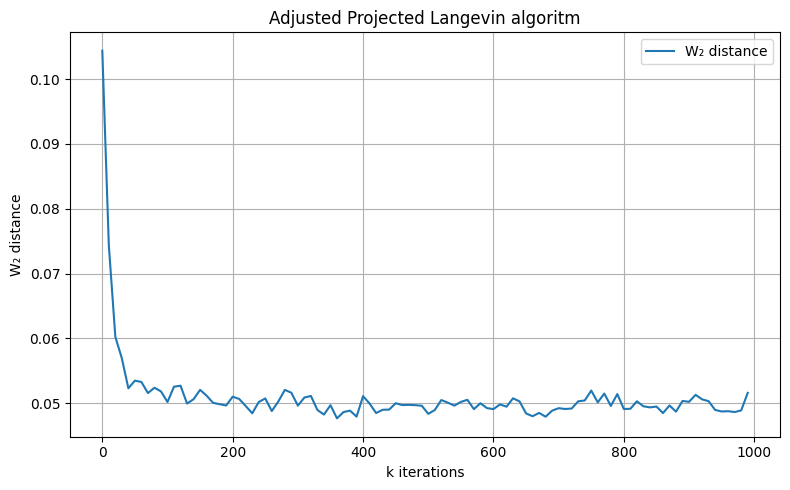

In [42]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(np.arange(0, max_iters, log_every), mean_distances, label='W₂ distance')
plt.xlabel("k iterations")
plt.ylabel("W₂ distance")
plt.title('Adjusted Projected Langevin algoritm')
plt.grid(True)
plt.legend()
plt.tight_layout()
plt.savefig("img/APLMC_c.png", dpi=300, bbox_inches='tight')

plt.show()